In [156]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM
from wheel.macosx_libfile import read_data

from extractor import addImagePath, textExtraction, imageExtraction, textExtractReverse

# 1. Check the max length of the text data


In [11]:
subUrlList = ['wendys','mcdonalds', 'mcdonalds_switzerland','mcdonaldscanada','sonicdrivein']
max_length = 0
sum_length = 0
for subUrl in subUrlList:
    dirPath = '../Data/Instagram/Filter_' + subUrl + '.csv'
    data = pd.read_csv(dirPath)
    
    for i in range(len(data['caption'])):
        sum_length += len(str(data['caption'][i]).split())
        if len(str(data['caption'][i]).split()) > max_length:
            max_length = len(str(data['caption'][i]).split())
            word = data['caption'][i]
print(max_length)
print(sum_length/len(data['caption']))

373
31.870794078061913


In [193]:
max_length = 0
word = ''
dirPath = '../Data/Oxford_HIC/oxford_hic_data.csv'
data = pd.read_csv(dirPath)
max_length = 0
sum_length = 0
index =0 
counter  = 5
# find the max word count of the text data['caption']
for i in range(len(data['caption'])):
    sum_length += len(str(data['caption'][i]).split())
    if len(str(data['caption'][i]).split()) > max_length:
        max_length = len(str(data['caption'][i]).split())
        word = data['caption'][i]
        index = i       
        #
print(max_length, i)
print(sum_length/len(data['caption']))
data.shape

C:\Users\USER\AppData\Local\Temp\ipykernel_5988\3251324240.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dirPath)


9729 3657846
10.514508397972905


(3657847, 3)

In [195]:
sum_length

38460463

# 2. Check the max word count of the text data

In [260]:
subUrlList = ['wendys','mcdonalds', 'mcdonalds_switzerland','mcdonaldscanada','sonicdrivein']
wordList = []
total = 0
for subUrl in subUrlList:
    dirPath = '../Data/Instagram/Filter_' + subUrl + '.csv'
    data = pd.read_csv(dirPath)
    
    for i in range(len(data['caption'])):
        for word in str(data['caption'][i]).split():
            if word not in wordList:
                wordList.append(word)
                total += 1
                
print(len(wordList))        
print(total)

15056
15056


In [261]:
wordList = []
total = 0
dirPath = '../Data/Oxford_HIC/oxford_hic_data.csv'
data = pd.read_csv(dirPath)

for i in range(len(data['caption'])):
    for word in str(data['caption'][i]).split():
        if word not in wordList:
            wordList.append(word)
            total += 1

print(len(wordList))        
print(total)

C:\Users\USER\AppData\Local\Temp\ipykernel_5988\496614120.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dirPath)


KeyboardInterrupt: 

# 3. Load the data and split the data

In [2]:
# if args.img - dir == 'Oxford_HIC':
#     dirPath = '../Data/Oxford_HIC/oxford_hic_data.csv'
#     imgPath = '../Data/Oxford_HIC/oxford_img/'
# else:
dirPath = '../Data/Instagram/Filter_' + 'wendys' + '.csv'
imgPath = '../Data/Instagram/' + 'wendys' + '_img/'
# load data
data = pd.read_csv(dirPath)
data = addImagePath(data, imgPath)
# split data
train, test = train_test_split(data, test_size=0.2, random_state=42)

train_text = textExtraction(train['caption'].tolist())
train_image = imageExtraction(train['image_id'])
train_funny_score = torch.tensor(train['funny_score'].to_numpy())
test_text = textExtraction(test['caption'])
test_image = imageExtraction(test['image_id'])
test_funny_score = torch.tensor(test['funny_score'].to_numpy())

In [3]:
train_text.shape, train_image.shape, train_funny_score.shape

(torch.Size([293, 64, 768]), torch.Size([293, 64, 768]), torch.Size([293]))

In [4]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(train_text, train_image, train_funny_score)
test_dataset = torch.utils.data.TensorDataset(test_text, test_image, test_funny_score)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. LLM Test

In [5]:
### 不確定是否為官方的 Gemini ############################################################################
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("describeai/gemini")
gemini = AutoModelForSeq2SeqLM.from_pretrained("describeai/gemini")
#######################################################################################################
gemini

C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [48]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",  torch_dtype=torch.bfloat16)
gemmaConfig =  AutoConfig.from_pretrained('google/gemma-2-2b')
########################################################################################################

C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\accelerate\utils\modeling.py:1405: UserWarning: Current model requires 6656 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto",  torch_dtype=torch.bfloat16)
gemmaConfig =  AutoConfig.from_pretrained('google/gemma-2-2b-it')
########################################################################################################

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gemma.to(device)
vocab_size = 256128  # 词汇表大小
embedding_dim = 768  # 嵌入维度，与你的图像嵌入维度相同
text_embedding = nn.Embedding(vocab_size, embedding_dim).to(device)

words = "👻🔥😂😁👍🤦‍♀️🤦‍♂️🤷‍♀️🤷‍♂️✌🤞😉😎🎶😢💖🎉🌹💋👏🐱‍💻🐱‍🐉🐱‍👓✔👀😃✨😆🤔🤢🎁🫢 ha ha"
tokens = tokenizer(words, truncation=True, padding= 'max_length', max_length=100, return_tensors="pt")
output = text_embedding(tokens['input_ids'].to(device))

import torch
import torch.nn.functional as F

def find_closest_embeddings(x, embedding_matrix, top_k=1):
    # Normalize both the input tensor x and the embedding matrix
    x = F.normalize(x, dim=1)  # Normalize input tensor along feature dimension
    embedding_matrix = F.normalize(embedding_matrix, dim=1)  # Normalize embedding matrix
    
    # Compute cosine similarity between x and embedding matrix
    similarity = torch.matmul(x, embedding_matrix.T)  # Shape: [10, 50265]
    
    # Find top-k closest embeddings for each tensor in x
    top_k_values, top_k_indices = torch.topk(similarity, top_k, dim=1)
    
    return top_k_indices, top_k_values


# print(output.squeeze(0).shape)
top_k_indices, top_k_values = find_closest_embeddings(output.squeeze(0), text_embedding.weight)
# top_k_indices.shape
indices = tokenizer.decode(top_k_indices.squeeze(-1))
print(indices)

torch.Size([100, 768])
<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><bos>👻🔥😂😁👍🤦‍♀️🤦‍♂️🤷‍♀️🤷‍♂️✌🤞😉😎🎶😢💖🎉🌹💋👏🐱‍💻🐱‍🐉🐱‍👓✔👀😃✨😆🤔🤢🎁🫢 ha ha


In [171]:
words = "👻🔥😂😁👍🤦‍♀️🤦‍♂️🤷‍♀️🤷‍♂️✌🤞😉😎🎶😢💖🎉🌹💋👏🐱‍💻🐱‍🐉🐱‍👓✔👀😃✨😆🤔🤢🎁🫢 ha ha"
tokens = tokenizer(words, truncation=True, padding= 'max_length', max_length=100, return_tensors="pt")
tokens

{'input_ids': tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      2, 242538, 237638, 236471, 238429, 237019, 240525,  67292,
         240525,  68399, 239921,  67292, 239921,  68399, 239529, 241807, 238309,
         238859, 240438, 240116, 239208, 239548, 240315, 240887, 238499, 242993,
         235879, 242482, 242993, 235879, 245092, 242993, 235879, 246943, 237488,
         239220, 239938, 236309, 239312, 238918, 241769, 241227, 248165,    661,
            661]]), 'attention_mask': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [127]:
gemma

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

# 4. Generator

In [5]:
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",  torch_dtype=torch.bfloat16)
gemma

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm()
        (post_attention_layernorm): Gemma2RMSNorm()
        (pre_feedforward_

In [5]:
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto", torch_dtype=torch.bfloat16)
gemma

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm()
        (post_attention_layernorm): Gemma2RMSNorm()
        (pre_feedforward_

In [5]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto",  torch_dtype=torch.bfloat16)
gemmaConfig =  AutoConfig.from_pretrained('google/gemma-2-2b-it')
########################################################################################################

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [130]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # self attention
        self.selfAttentionMultihead = nn.MultiheadAttention(768, 1)
        self.selfAttentionLayerNorm = nn.LayerNorm(768)
        self.selfAttentionLinear = nn.Linear(768, 768)
        self.selfAttentionLayerNorm2 = nn.LayerNorm(768)
        
        # multihead attention
        self.multiheadAttentionMultihead = nn.MultiheadAttention(768, 8)
        self.multiheadAttentionLinear = nn.Linear(768, 768)
        self.multiheadAttentionLayerNorm = nn.LayerNorm(768)
        
        # co-attention text
        self.coAttentionTextMultihead = nn.MultiheadAttention(768, 1)
        self.coAttentionTextLinear = nn.Linear(768, 768)
        self.coAttentionTextLayerNorm = nn.LayerNorm(768)

        # co-attention image
        self.coAttentionImageMultihead = nn.MultiheadAttention(768, 1)
        self.coAttentionImageLinear = nn.Linear(768, 768)
        self.coAttentionImageLayerNorm = nn.LayerNorm(768)
    
        # feed forward
        self.feedForwardLinear = nn.Linear(768, 768)
        self.feedForwardLayerNorm = nn.LayerNorm(768)
        
        # gemma
        self.gemmaLinearMaxTokens = nn.Linear(64, 16)
        self.gemmaLinearBefore = nn.Linear(768, gemmaConfig.vocab_size)
        self.gemmaSoftmax = nn.Softmax(dim=2)
        self.gemma = nn.Sequential(*list(gemma.children())[:-1])
        self.gemmaLm_head = nn.Sequential(*list(gemma.children())[1:])
        
        # funny score
        self.FunnyScorelinear1 = nn.Linear(768, 1)
        self.FunnyScorelinear2 = nn.Linear(64, 1)
        
    def self_multi(self, image, text):
        # self attention module
        self_out = self.selfAttentionMultihead(image, image, image)[0]
        self_out = self.selfAttentionLinear(self_out)
        self_out = self.selfAttentionLayerNorm(self_out + image)

        # multihead attention module
        multi_out = self.multiheadAttentionMultihead(text, text, text)[0]
        multi_out = self.multiheadAttentionLinear(multi_out)
        multi_out = self.multiheadAttentionLayerNorm(multi_out + text)
        
        return self_out, multi_out
        
    def co_attention(self, image, text):
        # co-attention image module
        visual_attending_textual = self.coAttentionTextMultihead(image, text, text)[0]
        visual_attending_textual = self.coAttentionTextLinear(visual_attending_textual)
        visual_attending_textual = self.coAttentionTextLayerNorm(visual_attending_textual + image)
        
        # co-attention text module
        textual_attending_visual = self.coAttentionTextMultihead(text, image, image)[0]
        textual_attending_visual = self.coAttentionTextLinear(textual_attending_visual)
        textual_attending_visual = self.coAttentionTextLayerNorm(textual_attending_visual + text) 
        
        return visual_attending_textual, textual_attending_visual              
        
    def gemmaGenerate(self, x):
        with torch.no_grad():
            # maximum 32 tokens
            x = self.gemmaLinearMaxTokens(x.transpose(1, 2)).transpose(1, 2)
            x = self.gemmaLinearBefore(x)
            x = self.gemmaSoftmax(x)
            # get max value of each row, total 32*64
            top_k_values, top_k_indices = torch.topk(x, 1, dim=2, largest=True)
            toGemma = textExtractReverse(top_k_indices).to(device)
            # 使用gemma作為model的一部分
            output = self.gemma(toGemma)
            # output[0] = last_hidden_state
            # output[1] = past_key_values
            
        return output[0]
               
    
    def forward(self, text, image):
        # max_seq_len = max(text.shape[1], image.shape[1])
        # text = nn.functional.pad(text, (0, 0, 0, max_seq_len - text.shape[1]))
        # image = nn.functional.pad(image, (0, 0, 0, max_seq_len - image.shape[1]))
        text = text.transpose(0, 1)
        image = image.transpose(0, 1)
        
        ######################### Transformer ######################### 
            # self attention
        self_out, multi_out = self.self_multi(image, text)
        # co-attention
        visual_attending_textual, textual_attending_visual = self.co_attention(self_out, multi_out)
        ###############################################################
        
        # feature fusion
        feature_fusion = visual_attending_textual + textual_attending_visual
        feature_fusion = self.feedForwardLinear(feature_fusion)
        feature_fusion = self.feedForwardLayerNorm(feature_fusion + feature_fusion)
        feature_fusion = feature_fusion.squeeze(-1)
        feature_fusion = feature_fusion.transpose(0, 1)
        ####################### gemma  generate #######################
        last_hidden_state = self.gemmaGenerate(feature_fusion)
        output_text = self.gemmaLm_head(last_hidden_state)
        ###############################################################
        
        ######################### funny score #########################
        output_funny_score = self.FunnyScorelinear1(feature_fusion).squeeze(-1)
        output_funny_score = self.FunnyScorelinear2(output_funny_score).squeeze(-1)
        ###############################################################
        
        return output_text, output_funny_score
    
    def generate(self, image, max_length = 100):
        generated_tokens = []
        generated_tokens.append(2) #<bos> = 2
        text = torch.zeros_like(image).to(device)
        text = text.transpose(0, 1)
        image = image.transpose(0, 1)
        tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
        
        # 有時後空格會失效，所以手動插入空格 <pad> = 0
        def insert_zeros(list):
            zeros = [0] * (2 * len(list) - 1)
            zeros[::2] = list
            return zeros
        
        lastTurn = False
        with torch.no_grad():
            for _ in range(max_length + 1):
                # Transformer
                # self attention
                self_out, multi_out = self.self_multi(image, text)
                # co-attention
                visual_attending_textual, textual_attending_visual = self.co_attention(self_out, multi_out)
                
                # feature fusion
                feature_fusion = visual_attending_textual + textual_attending_visual
                feature_fusion = self.feedForwardLinear(feature_fusion)
                feature_fusion = self.feedForwardLayerNorm(feature_fusion + feature_fusion)
                feature_fusion = feature_fusion.squeeze(-1)
                feature_fusion = feature_fusion.transpose(0, 1)
                
                # gemma generate
                last_hidden_state = self.gemmaGenerate(feature_fusion)
                output_text = self.gemmaLm_head(last_hidden_state)
                
                # funny score
                output_funny_score = self.FunnyScorelinear1(feature_fusion).squeeze(-1)
                output_funny_score = self.FunnyScorelinear2(output_funny_score).squeeze(-1)
                
                if lastTurn: # show final funny score
                    return generated_caption, output_funny_score
                else:
                    next_token_logits = output_text[:, -1, :]
                    next_token_probs = torch.softmax(next_token_logits, dim=-1)
                    next_token_id = torch.argmax(next_token_probs, dim=-1).item()
                    generated_tokens.append(next_token_id)
                    
                    generated_caption = insert_zeros(generated_tokens)
                    generated_caption = tokenizer.decode(generated_caption, skip_special_tokens=False)
                    generated_caption = generated_caption.replace("<pad>", " ").replace("  ", " ").split()
                    generated_caption = [word for word in generated_caption if word[0] != "<"]
                    generated_caption = " ".join(generated_caption)
                                               
                    text = textExtraction([generated_caption]).to(device)
                    text = text.transpose(0, 1)
                    
                    if next_token_id in gemmaConfig.eos_token_id or len(generated_caption.split()) > max_length: 
                        #<eos> = 1; <end_of_turn> = 107
                        lastTurn = True

In [ ]:
# vision encoder
        self.visual_encoder = VisionTransformerEncoder.from_config(vit_type = vit_type, adapter_type=adapter_type)
        # text encoder + multimodal decoder
        self.text_decoder = XBertLMHeadDecoder.from_config(med_config_path, False)

        self.prompt = prompt
        self.prompt_length = len(self.tokenizer(self.prompt).input_ids) - 1

        self.max_txt_len = max_txt_len
        self.adapter_type = adapter_type
        self.bert_adapter = bert_adapter
        self.tune_language = tune_language
        # if((self.bert_adapter or self.tune_language) and self.adapter_type == None):
        if visual_projection == "linear":
            self.VLBridge = nn.Linear(768, 768)
        elif visual_projection == "ViT_block":
            self.VLBridge = Block(dim=768,num_heads=12,)
        else:
            self.VLBridge = None

# 5. Discriminator

In [182]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Generator
        self.g_linearFake = nn.Linear(256000, 768)
        self.g_con_mlp1 = nn.Linear(768, 2)
        self.g_con_mlp2 = nn.Linear(128, 1)
        self.g_unc_mlp1 = nn.Linear(768, 1)
        self.g_unc_mlp2 = nn.Linear(64, 1)
        # Discriminator
        self.d_linearFake = nn.Linear(gemmaConfig.vocab_size, 768)
        self.d_con_mlp1_r2f = nn.Linear(768, 2)
        self.d_con_mlp2_r2f = nn.Linear(256, 1)
        self.d_con_mlp1_f2r = nn.Linear(768, 2)
        self.d_con_mlp2_f2r = nn.Linear(256, 1)
        self.d_con_mlp1_g = nn.Linear(768, 2)
        self.d_con_mlp2_g = nn.Linear(128, 1)
        self.d_con_mlp1_m = nn.Linear(768, 2)
        self.d_con_mlp2_m = nn.Linear(128, 1)
        self.d_unc_mlp1_r = nn.Linear(768, 1)
        self.d_unc_mlp2_r = nn.Linear(64, 1)
        self.d_unc_mlp1_g = nn.Linear(768, 1)
        self.d_unc_mlp2_g = nn.Linear(64, 1)
        self.d_unc_mlp1_m = nn.Linear(768, 1)
        self.d_unc_mlp2_m = nn.Linear(64, 1)
        
    def forward(self, real_text, fake_text, image):   
        # real_text = [batch_size, 64, 768]
        # fake_text = [batch_size, 256, 256000]
        # image = [batch_size, 64, 768]
        g_fake_text = self.g_linearFake(fake_text)
        
        d_fake_text = self.d_linearFake(fake_text)
        mismatched_text = torch.roll(real_text, 1, 0)
        
        # conditional (contrastive)
        C_r = torch.cat((real_text, image), dim=1)
        g_C_g = torch.cat((g_fake_text, image), dim=1)
        d_C_g = torch.cat((d_fake_text, image), dim=1)
        C_m = torch.cat((mismatched_text, image), dim=1)
        # contrastive discriminator
        d_C_r2f = torch.cat((C_r, d_C_g), dim=1)
        d_C_f2r = torch.cat((d_C_g, C_r), dim=1)
        ########################## Generator ##########################
        g_C_g = self.g_con_mlp1(g_C_g)
        g_C_g = self.g_con_mlp2(g_C_g.transpose(1,2)).squeeze(-1)
        ###############################################################
        
        ######################## Discriminator ########################
        d_C_r2f = self.d_con_mlp1_r2f(d_C_r2f)
        d_C_f2r = self.d_con_mlp1_f2r(d_C_f2r)
        d_C_g = self.d_con_mlp1_g(d_C_g)
        d_C_m = self.d_con_mlp1_m(C_m)
        d_C_r2f = self.d_con_mlp2_r2f(d_C_r2f.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_C_f2r = self.d_con_mlp2_r2f(d_C_f2r.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_C_g = self.d_con_mlp2_g(d_C_g.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_C_m = self.d_con_mlp2_m(d_C_m.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_con_output = torch.cat((d_C_r2f, d_C_f2r, d_C_g, d_C_m), dim=0)
        ###############################################################
        
        
        #### unconditional ####
        ########################## Generator ##########################
        g_UC_g = self.g_unc_mlp1(g_fake_text).squeeze(-1)
        g_UC_g = self.g_unc_mlp2(g_UC_g).squeeze(-1)
        ###############################################################
        
        ######################## Discriminator ########################
        d_UC_r  = self.d_unc_mlp1_r(real_text).squeeze(-1)
        d_UC_g  = self.d_unc_mlp1_g(d_fake_text).squeeze(-1)
        d_UC_m  = self.d_unc_mlp1_m(mismatched_text).squeeze(-1)
        d_UC_r = self.d_unc_mlp2_r(d_UC_r).squeeze(-1).unsqueeze(0)
        d_UC_g = self.d_unc_mlp2_g(d_UC_g).squeeze(-1).unsqueeze(0)
        d_UC_m = self.d_unc_mlp2_m(d_UC_m).squeeze(-1).unsqueeze(0)
        d_unc_output = torch.cat((d_UC_r, d_UC_g, d_UC_m), dim=0)
        ###############################################################
        # torch.Size([3, 32, 1])
        return g_C_g, g_UC_g, d_con_output, d_unc_output

In [183]:
# empty cuda memory
import gc
torch.cuda.empty_cache()
gc.collect()

303

In [184]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NetG = Generator().to(device)
NetD = Discriminator().to(device)
optimizer_G = optim.Adam(NetG.parameters(), lr=0.001)
optimizer_D = optim.Adam(NetD.parameters(), lr=0.001)
train_losses_FC = []
train_losses_G = []
train_losses_D = []
test_losses_FC = []
test_losses_G = []
test_losses_D = []
save = []
present_epoch = 1
best_train_loss_FC = 9999
best_train_loss_G = 9999
best_train_loss_D = 9999
best_test_loss_FC = 9999
best_test_loss_G = 9999
best_test_loss_D = 9999
loss_data = pd.DataFrame()

checkpoint = False
if checkpoint:
    checkpoint_G = torch.load('./Model/test_save/test_save_2NetG.pth')
    checkpoint_D = torch.load('./Model/test_save/test_save_2NetD.pth')
    NetG.load_state_dict(checkpoint_G['model_state_dict'])
    NetD.load_state_dict(checkpoint_D['model_state_dict'])
    optimizer_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint_D['optimizer_state_dict'])
    train_losses_FC.append(checkpoint_G['FC_loss'])
    train_losses_G.append(checkpoint_G['G_loss'])
    train_losses_D.append(checkpoint_G['D_loss'])
    present_epoch = checkpoint_G['epoch'] + 1

    

funnyScoreLoss = nn.MSELoss()

def generatorLoss(condition_logits, uncondition_logits):
    result_fake = (torch.zeros(uncondition_logits.shape[0])).to(device)
    con_loss = CrossEntropyLoss()(condition_logits, result_fake.to(torch.long))
    unc_loss = BCEWithLogitsLoss()(uncondition_logits, result_fake)
    loss = con_loss + unc_loss
    return loss

def discriminatorLoss(condition_logits, uncondition_logits):
    result_true = (torch.ones(uncondition_logits[0].shape[0])).to(device)
    result_fake = (torch.zeros(uncondition_logits[0].shape[0])).to(device)
    
    con_r2f = CrossEntropyLoss()(condition_logits[0], result_fake.to(torch.long))
    con_f2r = CrossEntropyLoss()(condition_logits[1], result_fake.to(torch.long))
    con_f = CrossEntropyLoss()(condition_logits[2], result_fake.to(torch.long))
    con_m = CrossEntropyLoss()(condition_logits[3], result_fake.to(torch.long))
    unc_r = BCEWithLogitsLoss()(uncondition_logits[0], result_true)
    unc_f = BCEWithLogitsLoss()(uncondition_logits[1], result_fake)
    unc_m = BCEWithLogitsLoss()(uncondition_logits[2], result_fake)
    loss = ((con_r2f + con_f2r)/2) + ((con_f + con_m)/2) + unc_r + ((unc_f + unc_m)/2)
    return loss

In [185]:
save_name = 'test'
if not os.path.exists('./Model/'+save_name):
    os.makedirs('./Model/'+save_name)
    
epochs = 2
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    print("---------------------------------------- epoch "+ str(epoch + present_epoch) +" ---------------------------------------")
    train_loss_FC = 0
    train_loss_G = 0
    train_loss_D = 0
    test_loss_FC = 0
    test_loss_G = 0
    test_loss_D = 0
    
    ###################################### Train ######################################
    with tqdm(train_loader, unit="batch") as tepoch:
        for text, image, funny_score in tepoch:
            ######################################################
                # (1) Generate fake caption
            ######################################################
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            g_con_logits, g_unc_logits, d_con_logits, d_unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            ######################################################
                # (3) Update Discriminator network
            #####################################################
            optimizer_D.zero_grad()
            loss_D = discriminatorLoss(d_con_logits, d_unc_logits)
            loss_D.backward(retain_graph=True)
            optimizer_D.step()
            train_loss_D += loss_D.item()
            ######################################################
                # (4) Update Generator network
            ######################################################
            optimizer_G.zero_grad()
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_FC.backward(retain_graph=True)
            train_loss_FC += loss_FC.item()
            loss_G = generatorLoss(g_con_logits, g_unc_logits)
            loss_G.backward()
            optimizer_G.step()
            train_loss_G += loss_G.item()
            ######################################################
            tepoch.set_postfix({'FC_loss': loss_FC.item(), 'G_loss': loss_G.item(), 'D_loss': loss_D.item()})
            ######################################################
    train_loss_FC /= len(train_loader)
    train_loss_G /= len(train_loader)
    train_loss_D /= len(train_loader)
    train_losses_FC.append(train_loss_FC)
    train_losses_G.append(train_loss_G)
    train_losses_D.append(train_loss_D)
    ###################################### Train ######################################
    
    
    ######################################  Test ######################################
    with tqdm(test_loader, unit="batch") as tepoch:
        for text, image, funny_score in tepoch:
            # Generator
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            # Discriminator
            gen_logits, con_logits, unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            # loss
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_G = generatorLoss(gen_logits)
            loss_D = discriminatorLoss(unc_logits, con_logits)
            test_loss_FC += loss_FC.item()
            test_loss_G += loss_G.item()
            test_loss_D += loss_D.item()
            tepoch.set_postfix({'FC_loss': test_loss_FC, 'G_loss': test_loss_G, 'D_loss': test_loss_D})
    test_loss_FC /= len(test_loader)
    test_loss_G /= len(test_loader)
    test_loss_D /= len(test_loader)
    test_losses_FC.append(test_loss_FC)
    test_losses_G.append(test_loss_G)
    test_losses_D.append(test_loss_D)
    ######################################  Test ######################################

    ######################################  Save ######################################
    hasSaved = False
    # 任一個loss小於最佳loss就存檔
    if train_loss_FC < best_train_loss_FC and test_loss_FC < best_test_loss_FC:
        best_train_loss_FC = train_loss_FC
        best_test_loss_FC = test_loss_FC
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    if train_loss_G < best_train_loss_G and test_loss_G < best_test_loss_G:
        best_train_loss_G = train_loss_G
        best_test_loss_G = test_loss_G
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    if train_loss_D < best_train_loss_D and test_loss_D < best_test_loss_D:
        best_train_loss_D = train_loss_D
        best_test_loss_D = test_loss_D
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    
    if hasSaved:
        save.append("V")
    else:
        save.append(" ")

    loss_data['train_FC'] = train_losses_FC
    loss_data['train_G'] = train_losses_G
    loss_data['train_D'] = train_losses_D
    loss_data['test_FC'] = test_losses_FC
    loss_data['test_G'] = test_losses_G
    loss_data['test_D'] = test_losses_D
    loss_data['save'] = save
    loss_data.to_csv('./Model/' + save_name + "/" + save_name + '_loss.csv', index=False)
    ######################################  Save ######################################

---------------------------------------- epoch 1 ---------------------------------------


  0%|          | 0/10 [00:00<?, ?batch/s]

torch.Size([32, 2]) torch.Size([32])


 10%|█         | 1/10 [03:04<27:39, 184.37s/batch, FC_loss=1.37, G_loss=2.31, D_loss=2.44]


KeyboardInterrupt: 

In [167]:
a = torch.rand(32,2)
target = torch.zeros(32).to(torch.long)
print(a.shape, target.shape)
CrossEntropyLoss()(a, target)

torch.Size([32, 2]) torch.Size([32])


tensor(0.6036)

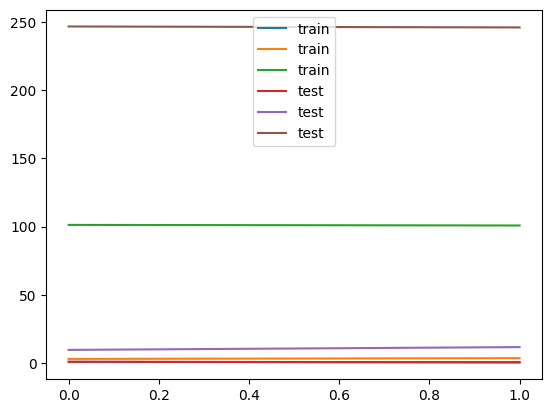

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_losses_FC, label='train')
plt.plot(train_losses_G, label='train')
plt.plot(train_losses_D, label='train')
plt.plot(test_losses_FC, label='test')
plt.plot(test_losses_G, label='test')
plt.plot(test_losses_D, label='test')
plt.legend()
plt.show()
# save plot
plt.savefig('./Model/' + save_name + "/" + save_name + '_loss.png')

In [12]:
# to csv
train_losses = pd.DataFrame({'train_FC': train_losses_FC, 'train_G': train_losses_G, 'train_D': train_losses_D})
test_losses = pd.DataFrame({'test_FC': test_losses_FC, 'test_G': test_losses_G, 'test_D': test_losses_D})
train_losses.to_csv('./Model/' + save_name + "/" + save_name + '_train_losses.csv', index=False)
test_losses.to_csv('./Model/' + save_name + "/" + save_name + '_test_losses.csv', index=False)

# Generate Test

In [24]:
test_image[0].shape

torch.Size([64, 768])

In [70]:
#load model
NetG = Generator().to(device)
NetD = Discriminator().to(device)
NetG.load_state_dict(torch.load('./Model/test_batch32/test_batch32_5NetG.pth'))
NetD.load_state_dict(torch.load('./Model/test_batch32/test_batch32_5NetD.pth'))
# train with load model
NetG.train()
NetD.train()


C:\Users\USER\AppData\Local\Temp\ipykernel_15460\3508553010.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NetG.load_state_dict(torch.load('./Model/test_batch32/test_ba

<All keys matched successfully>

In [71]:
# generate
NetG.eval()
NetD.eval()
image = test_image[0].unsqueeze(0).to(device)
output = NetG.generate(image, 100)
output

100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


(tensor([[[-0.2329,  0.4325,  0.4199,  ..., -0.4702, -0.1142, -0.0098]],
 
         [[ 0.1089,  0.3625,  0.8224,  ...,  0.2763,  0.0975, -0.0043]],
 
         [[-0.1282, -0.1454, -0.1592,  ...,  0.1126,  0.7090,  0.6611]],
 
         ...,
 
         [[-0.4177,  0.1868,  0.0531,  ..., -0.5458,  0.0338, -1.4983]],
 
         [[-0.1912,  0.1032,  0.4763,  ...,  0.7547,  0.7066, -0.5460]],
 
         [[-0.1003, -0.3331, -0.0245,  ..., -0.5132,  0.0633,  0.8948]]],
        device='cuda:0'),
 [2,
  540,
  235248,
  236193,
  235248,
  235248,
  235250,
  235274,
  35351,
  235254,
  605,
  6935,
  235276,
  235248,
  235248,
  235248,
  132385,
  235248,
  235265,
  235248,
  2173,
  235274,
  235248,
  2465,
  3682,
  236193,
  18824,
  235274,
  235248,
  11200,
  235276,
  235276,
  616,
  235248,
  235248,
  235248,
  235274,
  235248,
  235248,
  2012,
  235276,
  2012,
  236193,
  235248,
  235248,
  235248,
  235265,
  618,
  235276,
  669,
  235248,
  235248,
  24255,
  618,
  14383,

# 6. Adapter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NetG = Generator().to(device)
NetD = Discriminator().to(device)
optimizer_G = optim.Adam(NetG.parameters(), lr=0.001)
optimizer_D = optim.Adam(NetD.parameters(), lr=0.001)
train_losses_FC = []
train_losses_G = []
train_losses_D = []
test_losses_FC = []
test_losses_G = []
test_losses_D = []
save = []
present_epoch = 1
best_train_loss_FC = 9999
best_train_loss_G = 9999
best_train_loss_D = 9999
best_test_loss_FC = 9999
best_test_loss_G = 9999
best_test_loss_D = 9999
loss_data = pd.DataFrame()

checkpoint = False
if checkpoint:
    checkpoint_G = torch.load('./Model/test_save/test_save_2NetG.pth')
    checkpoint_D = torch.load('./Model/test_save/test_save_2NetD.pth')
    NetG.load_state_dict(checkpoint_G['model_state_dict'])
    NetD.load_state_dict(checkpoint_D['model_state_dict'])
    optimizer_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint_D['optimizer_state_dict'])
    train_losses_FC.append(checkpoint_G['FC_loss'])
    train_losses_G.append(checkpoint_G['G_loss'])
    train_losses_D.append(checkpoint_G['D_loss'])
    present_epoch = checkpoint_G['epoch'] + 1

    

funnyScoreLoss = nn.MSELoss()

def generatorLoss(generator_logits):
    result_fake = (torch.zeros(generator_logits[1].shape[0])).to(device)
    unc_loss = BCEWithLogitsLoss()(generator_logits[1], result_fake)
    con_loss = BCEWithLogitsLoss()(generator_logits[0], result_fake)
    loss = con_loss + unc_loss
    return loss

def discriminatorLoss(uncondition_logits, condition_logits):
    result_true = (torch.ones(condition_logits[0].shape[0])).to(device)
    result_fake = (torch.zeros(condition_logits[0].shape[0])).to(device)
    unc_r = BCEWithLogitsLoss()(condition_logits[0], result_true)
    unc_f = BCEWithLogitsLoss()(condition_logits[1], result_fake)
    unc_m = BCEWithLogitsLoss()(condition_logits[2], result_fake)
    con_r = BCEWithLogitsLoss()(uncondition_logits[0], result_true)
    con_f = BCEWithLogitsLoss()(uncondition_logits[1], result_fake)
    con_m = BCEWithLogitsLoss()(uncondition_logits[2], result_fake)
    loss = unc_r + ((unc_f + unc_m)/2) + con_r + ((con_f + con_m)/2)
    return loss

In [ ]:
save_name = '20241011'
if not os.path.exists('./Model/'+save_name):
    os.makedirs('./Model/'+save_name)
    
epochs = 10
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    print("---------------------------------------- epoch "+ str(epoch + present_epoch) +" ---------------------------------------")
    train_loss_FC = 0
    train_loss_G = 0
    train_loss_D = 0
    test_loss_FC = 0
    test_loss_G = 0
    test_loss_D = 0
    
    ###################################### Train ######################################
    with tqdm(train_loader, unit="batch") as tepoch:
        for text_b, image_b, funny_score_b in tepoch:
            print(text_b, image_b, funny_score_b)
            text, image, funny_score = OxfordDataset.tokenize_batch(text_b, image_b, funny_score_b)
            print(text.shape, image.shape, funny_score.shape)
            ######################################################
                # (1) Generate fake caption
            ######################################################
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            gen_logits, con_logits, unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            ######################################################
                # (3) Update Discriminator network
            #####################################################
            optimizer_D.zero_grad()
            loss_D = discriminatorLoss(unc_logits, con_logits)
            loss_D.backward(retain_graph=True)
            optimizer_D.step()
            train_loss_D += loss_D.item()
            ######################################################
                # (4) Update Generator network
            ######################################################
            optimizer_G.zero_grad()
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_FC.backward(retain_graph=True)
            train_loss_FC += loss_FC.item()
            loss_G = generatorLoss(gen_logits)
            loss_G.backward()
            optimizer_G.step()
            train_loss_G += loss_G.item()
            ######################################################
            tepoch.set_postfix({'FC_loss': loss_FC.item(), 'G_loss': loss_G.item(), 'D_loss': loss_D.item()})
            ######################################################
    train_loss_FC /= len(train_loader)
    train_loss_G /= len(train_loader)
    train_loss_D /= len(train_loader)
    train_losses_FC.append(train_loss_FC)
    train_losses_G.append(train_loss_G)
    train_losses_D.append(train_loss_D)
    ###################################### Train ######################################
    
    
    ######################################  Test ######################################
    with tqdm(test_loader, unit="batch") as tepoch:
        for text, image, funny_score in tepoch:
            # Generator
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            # Discriminator
            gen_logits, con_logits, unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            # loss
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_G = generatorLoss(gen_logits)
            loss_D = discriminatorLoss(unc_logits, con_logits)
            test_loss_FC += loss_FC.item()
            test_loss_G += loss_G.item()
            test_loss_D += loss_D.item()
            tepoch.set_postfix({'FC_loss': test_loss_FC, 'G_loss': test_loss_G, 'D_loss': test_loss_D})
    test_loss_FC /= len(test_loader)
    test_loss_G /= len(test_loader)
    test_loss_D /= len(test_loader)
    test_losses_FC.append(test_loss_FC)
    test_losses_G.append(test_loss_G)
    test_losses_D.append(test_loss_D)
    ######################################  Test ######################################
    
    ######################################  Save ######################################
    hasSaved = False
    # 任一個loss小於最佳loss就存檔
    if train_loss_FC < best_train_loss_FC and test_loss_FC < best_test_loss_FC:
        best_train_loss_FC = train_loss_FC
        best_test_loss_FC = test_loss_FC
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    if train_loss_G < best_train_loss_G and test_loss_G < best_test_loss_G:
        best_train_loss_G = train_loss_G
        best_test_loss_G = test_loss_G
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    if train_loss_D < best_train_loss_D and test_loss_D < best_test_loss_D:
        best_train_loss_D = train_loss_D
        best_test_loss_D = test_loss_D
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    
    if hasSaved:
        save.append("V")
    else:
        save.append(" ")

    loss_data['train_FC'] = train_losses_FC
    loss_data['train_G'] = train_losses_G
    loss_data['train_D'] = train_losses_D
    loss_data['test_FC'] = test_losses_FC
    loss_data['test_G'] = test_losses_G
    loss_data['test_D'] = test_losses_D
    loss_data['save'] = save
    loss_data.to_csv('./Model/' + save_name + "/" + save_name + '_loss.csv', index=False)
    ######################################  Save ######################################

In [1]:
import numpy as np
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AutoImageProcessor, Swinv2Model
from PIL import Image
import torch
from transformers import AutoConfig

def addImagePath(data, imgPath):
    data['image_id'] = data['image_id'].apply(lambda x: imgPath + str(x) + '.jpg')
    return data

def textExtraction(text_data):
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
    gemmaConfig = AutoConfig.from_pretrained('google/gemma-2-2b-it')
    vocab_size = gemmaConfig.vocab_size  # 詞彙表大小

    embedding_dim = 768  # 嵌入维度，與你的圖片嵌入维度相同
    text_embedding = nn.Embedding(vocab_size, embedding_dim)

    all_features = []
    for text in (text_data):
        tokens = tokenizer(text, padding='longest', return_tensors='pt')
        output = text_embedding(tokens['input_ids'])
        linear = torch.nn.Linear(output.shape[1], 64)
        projected_output = linear(output.transpose(1, 2)).transpose(1, 2)
        all_features.append(projected_output)
    return torch.cat(all_features)

def textExtractReverse(data):
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

    # 有時後空格會失效，所以手動插入空格 <pad> = 0
    def insert_zeros(tensor):
        zeros = torch.zeros(tensor.shape[0], tensor.shape[1] * 2 - 1)
        zeros[:, ::2] = tensor
        zeros = zeros.to(int)
        return zeros

    reverse_data = insert_zeros(data.squeeze(-1))
    # reverse the token
    reverse = tokenizer.batch_decode(reverse_data, skip_special_tokens=False)
    # tokenize with gemma-2b
    tokenizer_gemma = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
    prompt = "Write a humor memetic post for Instagram with the following elements: "
    # all_features = []
    for i, text in enumerate(reverse):
        text = text.replace("<pad>", " ").replace("  ", " ")
        text = text.split()
        text = ', '.join(text)
        reverse[i] = prompt + text + "."
    tokens = tokenizer_gemma(reverse, padding='max_length', max_length=64, return_tensors='pt')
    # all_features.append(tokens['input_ids'])
    return tokens['input_ids']

# 定義批量處理和提取特徵的函數
def imageExtraction(image_data):
    # 加載 Swinv2 模型和處理器
    image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
    swin = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

    # 將模型設置為評估模式
    swin.eval()

    # 如果有 GPU，可以將模型移動到 GPU 上
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    swin.to(device)

    all_features = []
    for image_path in (image_data):
        with torch.no_grad():
            # 加載並預處理圖像
            image = Image.open(image_path).convert('RGB')
            image = np.array(image)
            image = image[:, :, :3]
            # 使用 image_processor 將 batch 圖片處理成適合模型的格式
            inputs = image_processor(image, return_tensors="pt")
            # 將 inputs 放到 GPU 上（如果可用）
            inputs.to(device)
            # 獲取 Swinv2 模型的輸出
            outputs = swin(**inputs)
            last_hidden_states = outputs.last_hidden_state
            # 儲存特徵
            last_hidden_states = last_hidden_states.cpu()
            all_features.append(last_hidden_states)
    return torch.cat(all_features)



In [2]:
import pandas as pd
import tqdm as tqdm
dirPath = '../Data/Oxford_HIC/Filtered_oxford_hic_data.csv'
data = pd.read_csv(dirPath)
data = addImagePath(data, '../Data/Oxford_HIC/oxford_img/')
with tqdm.tqdm(total=data.shape[0]) as pbar:
    for i in range(data.shape[0]):
        image_path = data['image_id'][i]
        try:
            image = Image.open(image_path).convert('RGB')
        except:
            print(image_path)
        pbar.update(1)

  0%|          | 8975/3398160 [00:03<22:26, 2517.71it/s]

../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg
../Data/Oxford_HIC/oxford_img/bokete_966.jpg


  0%|          | 9829/3398160 [00:03<21:28, 2628.78it/s]

../Data/Oxford_HIC/oxford_img/bokete_966.jpg


  0%|          | 12347/3398160 [00:04<20:46, 2715.94it/s]

../Data/Oxford_HIC/oxford_img/bokete_966.jpg


  1%|          | 24906/3398160 [00:09<21:39, 2596.04it/s]

../Data/Oxford_HIC/oxford_img/bokete_2495.jpg
../Data/Oxford_HIC/oxford_img/bokete_2495.jpg
../Data/Oxford_HIC/oxford_img/bokete_2495.jpg


  1%|          | 31555/3398160 [00:12<20:52, 2687.18it/s]

../Data/Oxford_HIC/oxford_img/bokete_3049.jpg


  2%|▏         | 78074/3398160 [00:29<21:03, 2627.36it/s]

../Data/Oxford_HIC/oxford_img/bokete_6997.jpg
../Data/Oxford_HIC/oxford_img/bokete_6997.jpg
../Data/Oxford_HIC/oxford_img/bokete_6997.jpg


  3%|▎         | 85056/3398160 [00:32<20:06, 2746.00it/s]

../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg
../Data/Oxford_HIC/oxford_img/bokete_7487.jpg


  3%|▎         | 98382/3398160 [00:37<22:22, 2458.25it/s]

../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg
../Data/Oxford_HIC/oxford_img/bokete_8176.jpg


  4%|▍         | 147720/3398160 [00:59<26:00, 2083.13it/s]

../Data/Oxford_HIC/oxford_img/bokete_12501.jpg


  9%|▉         | 302766/3398160 [02:27<36:12, 1424.97it/s] 

../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg
../Data/Oxford_HIC/oxford_img/bokete_25616.jpg


  9%|▉         | 303413/3398160 [02:28<33:43, 1529.36it/s]

../Data/Oxford_HIC/oxford_img/bokete_25616.jpg


  9%|▉         | 306121/3398160 [02:29<34:53, 1477.03it/s]

../Data/Oxford_HIC/oxford_img/bokete_25616.jpg


 26%|██▌       | 871760/3398160 [06:27<17:09, 2454.15it/s]

../Data/Oxford_HIC/oxford_img/bokete_67874.jpg
../Data/Oxford_HIC/oxford_img/bokete_67874.jpg
../Data/Oxford_HIC/oxford_img/bokete_67874.jpg
../Data/Oxford_HIC/oxford_img/bokete_67874.jpg
../Data/Oxford_HIC/oxford_img/bokete_67874.jpg
../Data/Oxford_HIC/oxford_img/bokete_67874.jpg


 26%|██▌       | 879298/3398160 [06:31<16:58, 2472.73it/s]

../Data/Oxford_HIC/oxford_img/bokete_68584.jpg
../Data/Oxford_HIC/oxford_img/bokete_68584.jpg
../Data/Oxford_HIC/oxford_img/bokete_68584.jpg
../Data/Oxford_HIC/oxford_img/bokete_68584.jpg
../Data/Oxford_HIC/oxford_img/bokete_68584.jpg
../Data/Oxford_HIC/oxford_img/bokete_68584.jpg


 26%|██▋       | 894582/3398160 [06:37<17:12, 2424.37it/s]

../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg
../Data/Oxford_HIC/oxford_img/bokete_69659.jpg


 27%|██▋       | 912074/3398160 [06:44<17:42, 2339.58it/s]

../Data/Oxford_HIC/oxford_img/bokete_70929.jpg


 28%|██▊       | 952215/3398160 [07:01<16:54, 2409.94it/s]

../Data/Oxford_HIC/oxford_img/bokete_70929.jpg


 28%|██▊       | 968082/3398160 [07:08<18:30, 2189.06it/s]

../Data/Oxford_HIC/oxford_img/bokete_12501.jpg
../Data/Oxford_HIC/oxford_img/bokete_12501.jpg
../Data/Oxford_HIC/oxford_img/bokete_12501.jpg
../Data/Oxford_HIC/oxford_img/bokete_12501.jpg


100%|██████████| 3398160/3398160 [22:24<00:00, 2526.94it/s]


# Load Data

In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AutoImageProcessor, Swinv2Model
from PIL import Image
import torch
from transformers import AutoConfig
from extractor import textExtraction, textExtractReverse, imageExtraction, addImagePath
import tqdm
import gc

In [2]:
dirPath = '../Data/Oxford_HIC/Filtered_oxford_hic_data.csv'
imgPath = '../Data/Oxford_HIC/oxford_img/'

data = pd.read_csv(dirPath)

In [6]:
columns = ['image_id', 'image']
new_data = pd.DataFrame(columns=columns)
# new_data['image_id'] = data['image_id'].astype(object)
# new_data['caption'] = new_data['caption'].astype(object)
# new_data['funny_score'] = data['funny_score'].astype(float)

In [3]:
idcounter = 0
def captionID():
    global idcounter
    idcounter += 1
    idName = 'caption' + str(idcounter)
    return idName
    

In [4]:
data['caption_id'] = data['caption'].apply(lambda x: captionID())

In [5]:
data.shape

(3398081, 4)

In [15]:
data.to_csv('../Data/Oxford_HIC/CaptionID_oxford_hic_data.csv', index=False)

In [6]:
data.head()

,image_id,caption,funny_score,caption_id
0,bokete_0,My driver's license photo,0.0,caption1
1,bokete_1,Refugee relief.,0.0,caption2
2,bokete_2,Now! I think I stepped on a cat! What? Really?...,0.0,caption3
3,bokete_3,You wouldn't know I was reading a comic book.,0.0,caption4
4,bokete_4,"Oh no! I forgot my ・・・・ clothes!""",0.0,caption5


# Save textExtraction

In [7]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, BCELoss
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

from extractor import addImagePath, textExtraction, imageExtraction, textExtractReverse

eps = torch.finfo(torch.bfloat16).eps

In [8]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto", torch_dtype=torch.bfloat16)
gemmaConfig =  AutoConfig.from_pretrained('google/gemma-2-2b-it')
########################################################################################################

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# 50000 一個round直到跑完
start_index = 0
end_index = 50000
filename = 0
while start_index < data.shape[0]+1:
    a = textExtraction(tokenizer, gemmaConfig, data['caption'][start_index:end_index].tolist())
    with tqdm(total=a.shape[0], position=0, leave=True) as pbarr:
        for j in range(a.shape[0]):
            if os.path.exists('../Data/Oxford_HIC/CaptionData/'+data['caption_id'][j]+'.pt'):
                pbarr.update(1)
                continue
            caption = a[j].clone().detach()
            torch.save(caption, '../Data/Oxford_HIC/CaptionData/'+data['caption_id'][j]+'.pt')
            pbarr.update(1)
            del caption
            gc.collect()
    # clear memory
    del a
    gc.collect()
    start_index = end_index
    if end_index == data.shape[0]:
        break
    if end_index + 50000 > data.shape[0]:
        end_index = data.shape[0]
    else:
        end_index += 50000
        

  0%|          | 61/50000 [00:03<58:33, 14.21it/s]

In [10]:
text = torch.load('../Data/Oxford_HIC/CaptionData/'+data['caption_id'][0]+'.pt', weights_only=False)
print(text.shape)
print(text.dtype)
print(text)

torch.Size([64, 768])
torch.float32
tensor([[-1.0821, -1.3760, -0.7178,  ...,  0.0934, -0.6337,  1.8725],
        [ 0.0397, -0.3388,  1.1762,  ...,  0.7794,  0.4113,  0.6521],
        [-0.3500, -0.1279,  0.0934,  ...,  0.6557,  1.3321,  0.6173],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [ ]:
# 無 warning 版本
# 50000 一個round直到跑完
start_index = 0
end_index = 10000
filename = 1
while start_index < data.shape[0]+1:   
    with tqdm.tqdm(total=data.shape[0], position=0, leave = True) as pbars:
        # tasks = pbars.add_task("[white]Processing...", total=data.shape[0])
        a = textExtraction(data['caption'][start_index:end_index].tolist())
        df_extended = pd.DataFrame([a]).T
        df = pd.DataFrame(data[start_index:end_index])
        df['caption'] = df_extended
        new_data = pd.concat([new_data, df], ignore_index=True)
        # pbars.set_postfix({'filename': filename, 'Status': ' Saving'})
        new_data.to_csv('../Data/Oxford_HIC/Caption'+str(filename)+'_oxford_hic_data.csv', index=False)
        del a
        del df_extended
        del df
        gc.collect()
        pbars.update(end_index)
        pbars.set_postfix({'filename': filename})
        # pbars.set_postfix({'filename': filename, 'Status': ' Loading'})
        new_data = pd.read_csv('../Data/Oxford_HIC/Caption'+str(filename)+'_oxford_hic_data.csv')
        start_index = end_index
        if end_index == data.shape[0]:
            break
        if end_index + 10000 > data.shape[0]:
            end_index = data.shape[0]
        else:
            end_index += 10000

In [3]:
data1 = pd.read_csv('../Data/Oxford_HIC/Caption_oxford_hic_data.csv')
data2 = pd.read_csv('../Data/Oxford_HIC/Caption2_oxford_hic_data.csv')
data = pd.concat([data1, data2], ignore_index=True)
data.to_csv('../Data/Oxford_HIC/Caption_Done_oxford_hic_data.csv', index=False)

In [20]:
data.shape

(3398081, 3)

# Save imageExtraction

In [4]:
dirPath = '../Data/Oxford_HIC/Filtered_oxford_hic_data.csv'
imgPath = '../Data/Oxford_HIC/oxford_img/'

data = pd.read_csv(dirPath)

In [5]:
img_names = data['image_id'].unique()
len(img_names)

116649

In [7]:
column = ['image_id', 'image']
new_data = pd.DataFrame(columns=column)

In [8]:
imgPath = '../Data/Oxford_HIC/oxford_img/'
start_index = 50000
end_index = 60000
filename = 2
start = 0
with tqdm.tqdm(total=len(img_names), position=0, leave=True) as pbars:
    while start_index < len(img_names):
        if start == 0:
            pbars.update(start_index)
            start = 1
        if start_index % 30000 == 0 :
            column = ['image_id', 'image']
            new_data = pd.DataFrame(columns=column)
            filename += 1
        else:
            new_data = pd.read_csv('../Data/Oxford_HIC/Image'+ str(filename) +'_oxford_hic_data.csv')
        
        image_path = np.array([imgPath + str(item) + '.jpg' for item in img_names[start_index:end_index]])
        image = imageExtraction(image_path)
        df_extended1 = pd.DataFrame([image]).T
        df_extended1.columns = ['image']
        df_extended2 = pd.DataFrame(img_names[start_index:end_index])
        df_extended2.columns = ['image_id']
        df_extended = pd.DataFrame(columns=column)
        df_extended['image_id'] = df_extended2['image_id'].values
        df_extended['image'] = df_extended1['image'].values
        new_data = pd.concat([new_data, df_extended], ignore_index=True)
        new_data.to_csv('../Data/Oxford_HIC/Image'+ str(filename) +'_oxford_hic_data.csv', index=False)
        All = (filename-1)*30000 + new_data.shape[0]
        pbars.set_postfix({'filename': filename, 'Done': new_data.shape[0], 'All': All})
        del image
        del df_extended1
        del df_extended2
        del df_extended
        del image_path
        del new_data
        gc.collect()
        pbars.update(10000)
        
        start_index = end_index
        if end_index == len(img_names):
            break
        if end_index + 10000 > len(img_names):
            end_index = len(img_names)
        else:
            end_index += 10000

100%|██████████| 6649/6649 [07:03<00:00, 15.69it/s]1it/s, filename=4, Done=2e+4, All=110000]
120000it [3:27:05,  9.66it/s, filename=4, Done=26649, All=116649]                            


# Get Image with Index (選擇不要用這個)

In [2]:
import pandas as pd
dirPath = '../Data/Oxford_HIC/Filtered_oxford_hic_data.csv'
data = pd.read_csv(dirPath)


116649

In [9]:
img_names = data['image_id'].unique().tolist()
len(img_names)

116649

In [8]:
# get index of img_names
index = []
for i in range(len(img_names)):
[data['image_id'][0] == img_names].index

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [11]:
def getFile(imgName):
    index = img_names.index(imgName)
    file = index // 30000
    pbar.update(1)
    return file
def getIndex(imgName):
    index = img_names.index(imgName)
    idx = index % 30000
    pbar.update(1)
    return idx

In [13]:
import tqdm
new_data = data
with tqdm.tqdm(total=data.shape[0]) as pbar:
    new_data['image_file'] = new_data['image_id'].apply(lambda x: getFile(x))
with tqdm.tqdm(total=data.shape[0]) as pbar:
    new_data['image_index'] = new_data['image_id'].apply(lambda x: getIndex(x))
new_data.to_csv('../Data/Oxford_HIC/Image_index_oxford_hic_data.csv', index=False)

100%|██████████| 3398081/3398081 [1:08:23<00:00, 828.04it/s]


In [11]:
import pandas as pd
i = 1
fileName = '../Data/Oxford_HIC/ImageList/Image'+str(i)+'_oxford_hic_data.csv'
data = pd.read_csv(fileName)
print(data.shape)
data.drop(columns=['image_id'], axis=1, inplace=True)
print(data.shape)
fileName = '../Data/Oxford_HIC/Image'+str(i)+'_oxford_hic_data.csv'
data.to_csv(fileName, index=False)
del data
gc.collect()

(30000, 2)
(30000, 1)


NameError: name 'gc' is not defined

# Save ImageData with pt

In [1]:
import ast
import pandas as pd
import torch
# new_data = pd.DataFrame()
# temp = pd.read_csv('../Data/Oxford_HIC/Caption2_oxford_hic_data.csv', iterator=True, chunksize=10000)
# new_data = pd.concat(temp, ignore_index=True)
new_data = pd.read_csv('../Data/Oxford_HIC/Caption2_oxford_hic_data.csv')

In [ ]:
new_data['caption'] = new_data['caption'].apply(lambda x: torch.tensor(ast.literal_eval(x)))

In [1]:
import tqdm
import ast
import pandas as pd
import torch
import gc
import os
for i in range(4, 5):
    temp = pd.read_csv('../Data/Oxford_HIC/ImageList/Image'+str(i)+'_oxford_hic_data.csv', iterator=True, chunksize=5000)
    data = pd.concat(temp, ignore_index=True)
    del temp
    gc.collect()
    with tqdm.tqdm(total=data.shape[0]) as pbar:
        for j in range(data.shape[0]):
            if os.path.exists('../Data/Oxford_HIC/ImageData/'+data['image_id'][j]+'.pt'):
                pbar.update(1)
                continue
            image = torch.tensor(ast.literal_eval(data['image'][j])).to(torch.float32)
            torch.save(image, '../Data/Oxford_HIC/ImageData/'+data['image_id'][j]+'.pt')
            pbar.update(1)
            del image
            gc.collect()
    del data
    gc.collect()

100%|██████████| 26649/26649 [2:52:56<00:00,  2.57it/s]  


In [9]:
# save as pt
image = torch.tensor(ast.literal_eval(data['image'][0])).to(torch.float32)
torch.save(image, '../Data/Oxford_HIC/ImageData/'+data['image_id'][0]+'.pt')

In [13]:
image = torch.load('../Data/Oxford_HIC/ImageData/'+data['image_id'][0]+'.pt', weights_only=False)
print(image.shape)
print(image.dtype)
print(image)

torch.Size([64, 768])
torch.float32
tensor([[-1.8035,  0.5202,  0.4408,  ...,  0.0865, -0.4930, -2.6763],
        [ 0.2728,  1.3702,  0.0285,  ...,  0.4052, -0.2069,  0.1937],
        [-0.3072,  2.7029,  2.3379,  ..., -0.4808, -0.6480, -0.2691],
        ...,
        [-2.5183, -1.1495,  1.1463,  ..., -0.0928, -0.4463, -0.2784],
        [-2.0778, -0.6066, -0.2198,  ...,  0.0085,  0.5643, -0.0705],
        [-0.7022, -0.2345, -0.1471,  ..., -0.4195,  0.8525,  0.2226]])


In [7]:
# data = pd.read_csv('../Data/Oxford_HIC/ImageList/Image'+str(i)+'_oxford_hic_data.csv')
image = torch.tensor(ast.literal_eval(data['image'][0])).to(torch.float32)
print(image.shape)
print(image.dtype)
print(image)

torch.Size([64, 768])
torch.float32
tensor([[-1.8035,  0.5202,  0.4408,  ...,  0.0865, -0.4930, -2.6763],
        [ 0.2728,  1.3702,  0.0285,  ...,  0.4052, -0.2069,  0.1937],
        [-0.3072,  2.7029,  2.3379,  ..., -0.4808, -0.6480, -0.2691],
        ...,
        [-2.5183, -1.1495,  1.1463,  ..., -0.0928, -0.4463, -0.2784],
        [-2.0778, -0.6066, -0.2198,  ...,  0.0085,  0.5643, -0.0705],
        [-0.7022, -0.2345, -0.1471,  ..., -0.4195,  0.8525,  0.2226]])


In [5]:
# caption = pd.read_csv('../Data/Oxford_HIC/Caption1_oxford_hic_data.csv')
captionData = torch.tensor(ast.literal_eval(caption['caption'][0])).to(torch.float32)
print(captionData.shape)
print(captionData.dtype)
print(captionData)

torch.Size([64, 768])
torch.float32
tensor([[ 0.5960, -1.5175,  0.4210,  ..., -0.4031, -1.3697,  0.1927],
        [ 0.4261,  1.9516,  0.3017,  ...,  1.2013,  1.6093, -1.0158],
        [-1.1612, -0.3983, -0.2365,  ...,  0.7160, -1.8396, -0.4191],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
